In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import imgaug as ia
from imgaug import augmenters as iaa

In [ ]:

splits = ["train[:80%]", "train[80%:90%]", "train[90%:]"]

# load the dataset given the splits defined above
splits, info = tfds.load("horses_or_humans", with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits["train"].num_examples
num_classes = info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/incomplete.I9OT89_3.0.0/horses_or_humans-train.tfrecord*.…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/incomplete.I9OT89_3.0.0/horses_or_humans-test.tfrecord*..…

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

# Resize the image and normalize the pixel values
def format_image(image, label):
    """
       Function to resize the image and normalise the pixel_values
    """
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

# Prepare training, test and validation batches
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(format_image).batch(1)

In [ ]:

def build_model():
    """
       Define the model architecture here
    """
    # load the base model
    base_model = vgg16.VGG16(input_shape=IMAGE_SIZE + (3,),
                           weights="imagenet",
                           include_top=False)

    # Freezing the earlier layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Adding a Global Average Pooling layer
    output = layers.GlobalAveragePooling2D()(base_model.output)

    # Define the outputs
    output = layers.Dense(2, activation="softmax")(output)
    # Set the inputs and outputs of the model in using Tf Functional API syntax
    model = Model(base_model.input, output)
    # Initalize the optimizer
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    # Complile the model
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])

    # Display the model summary
    model.summary()

    return model

model = build_model()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                              

In [ ]:

# Select all the layers for which you want visualize the outputs
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

print("Layers that will be used for visualization: ")
print(layer_names)

def get_CAM(processed_image, actual_label, layer_name='block5_conv3'):
    """
       Function for grad cam implementation
    """
    model_grad = Model([model.inputs],
                     [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        # Monitor the conv_output_values using gradient tape
        tape.watch(conv_output_values)
        pred_prob = predictions[:,1]

        # Typecast label to float to match the datatype of the rest of loss calculation
        actual_label = tf.cast(actual_label, dtype=tf.float32)

        # add a tiny value to avoid log of 0
        smoothing = 0.00001

        # Calculate loss as binary cross entropy loss
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")

    # Get the gradient of the loss with respect to the outputs of the last conv layer
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0, 1, 2))

    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()

    # Weight the convolution outputs with the computed gradients
    for i in range(512):
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()

    del model_grad, conv_output_values, grads_values, loss

    return heatmap

Layers that will be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


In [ ]:

def show_sample(idx=None):
    """
    Visualization function. idx=None sets the image index as random
    """
    if idx:
        for img, label in test_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]
    else:
        for img, label in test_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]

    sample_image_processed = np.expand_dims(sample_image, axis=0)
    activations = vis_model.predict(sample_image_processed)

    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]

    sample_activation = activations[0][0,:,:,16]

    sample_activation -= sample_activation.mean()
    sample_activation /= sample_activation.std()

    sample_activation *= 255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)

    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap * 255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_image = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_image, 0.8, heatmap.astype("float32"), 2e-3, 0.0)

    f, ax = plt.subplots(2, 2, figsize=(15, 8))

    ax[0, 0].imshow(sample_image)
    ax[0, 0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0, 0].axis("off")

    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')

    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')

    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')

    plt.tight_layout()
    plt.show()

    return activations

1/1 [==============================] - 1s 1s/step
binary loss: [2.0441768]


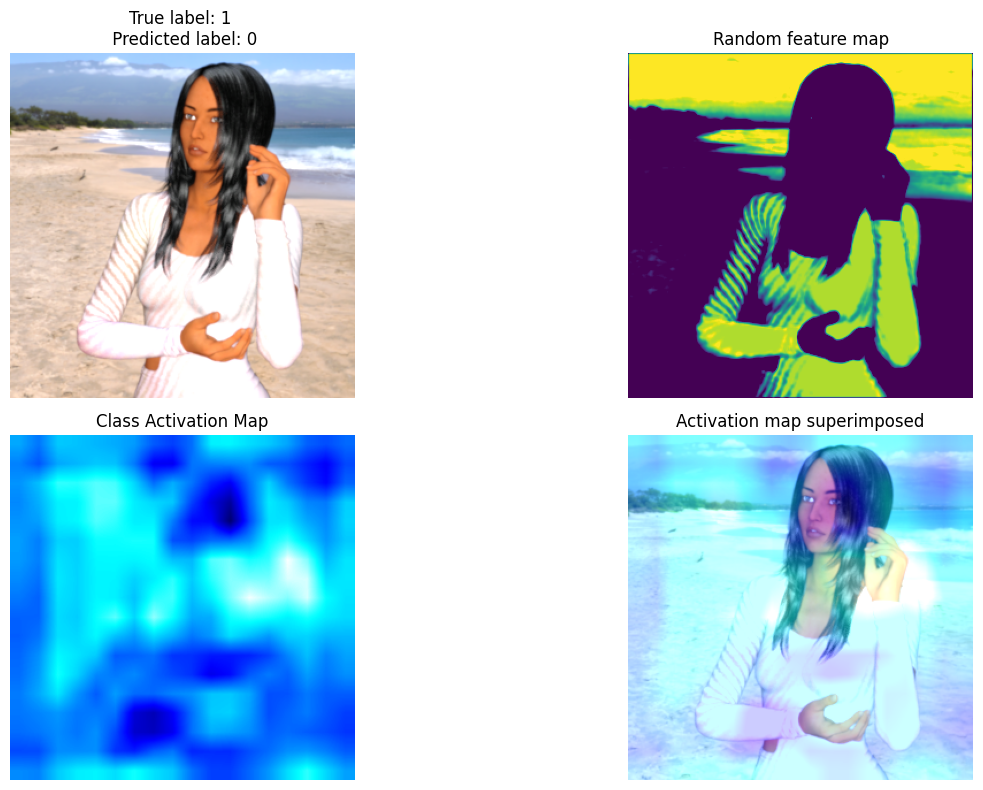

In [ ]:
# Choose an image index to show, or leave it as None to get a random image
activations = show_sample(idx=8)